# Contrastive Training with Groove Radar

Train the StepMania difficulty classifier with contrastive learning using groove radar similarity.

**Multi-task learning:**
- Classification loss on anchor samples (CrossEntropy)
- Contrastive loss on triplets (TripletMarginLoss with adaptive margins)

**Key components:**
- `GrooveRadar`: DDR-style 5-value feature vector (Stream, Voltage, Air, Freeze, Chaos)
- `TripletSelector`: Selects positive/negative pairs based on groove radar similarity
- `ContrastiveTripletDataset`: Serves triplets for contrastive learning

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# Import project modules
from src.data import (
    StepManiaDataset,
    ContrastiveTripletDataset,
    create_contrastive_dataset,
    DIFFICULTY_NAMES
)
from src.data.groove_radar import GrooveRadar
from src.data.similarity import GrooveRadarSimilarity, TripletSelector
from src.models.classifier import LateFusionClassifier
from src.training import ContrastiveTrainer

## 1. Configuration

In [3]:
# Load configuration
config_path = Path('../config/model_config.yaml')
with open(config_path, 'r') as f:
    full_config = yaml.safe_load(f)

classifier_config = full_config['classifier']
training_config = full_config['training']
contrastive_config = full_config['contrastive']

print("=== Classifier Config ===")
for k, v in classifier_config.items():
    if not isinstance(v, dict):
        print(f"  {k}: {v}")

print("\n=== Contrastive Config ===")
for k, v in contrastive_config.items():
    print(f"  {k}: {v}")

=== Classifier Config ===
  audio_features_dim: 23
  chart_sequence_dim: 4
  max_sequence_length: 1440
  fusion_dim: 256
  num_classes: 4
  classifier_dropout: 0.2
  backbone_blocks: 4
  backbone_dropout: 0.4
  fusion_type: late
  pooling_type: mean_max
  head_type: classification
  classifier_hidden_dim: 64
  use_groove_radar: True
  radar_hidden_dim: 32
  radar_dropout: 0.3
  use_projection_head: False
  projection_dim: 128

=== Contrastive Config ===
  enabled: True
  contrastive_loss: triplet_radar
  triplet_margin: 1.0
  margin_scale: 0.5
  infonce_temperature: 0.07
  classification_weight: 0.8
  contrastive_weight: 1.0
  positive_percentile: 20.0
  negative_percentile: 80.0
  same_difficulty_only: False
  radar_weights: [1.0, 1.0, 1.0, 1.0, 1.0]
  precompute_triplets: True
  resample_epoch: True


In [4]:
# Dataset paths - update these for your environment
DATA_DIR = Path('../data')  # Parent directory containing chart folders
CHECKPOINT_DIR = Path('../checkpoints/contrastive')
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
  GPU: NVIDIA GeForce RTX 3060


## 2. Load Data

In [5]:
import glob
from sklearn.model_selection import train_test_split

# Find all chart files
chart_patterns = ['**/*.sm', '**/*.ssc']
chart_files = []
for pattern in chart_patterns:
    chart_files.extend(glob.glob(str(DATA_DIR / pattern), recursive=True))

print(f"Found {len(chart_files)} chart files")

# Split chart files into train/val/test
train_files, temp_files = train_test_split(
    chart_files, test_size=(VAL_RATIO + TEST_RATIO), random_state=42
)
val_files, test_files = train_test_split(
    temp_files, test_size=(TEST_RATIO / (VAL_RATIO + TEST_RATIO)), random_state=42
)

print(f"\nChart file splits:")
print(f"  Train: {len(train_files)}")
print(f"  Val: {len(val_files)}")
print(f"  Test: {len(test_files)}")

# Create datasets
max_seq_len = classifier_config.get('max_sequence_length', 1440)

train_dataset = StepManiaDataset(
    chart_files=train_files,
    audio_dir=str(DATA_DIR),
    max_sequence_length=max_seq_len
)

val_dataset = StepManiaDataset(
    chart_files=val_files,
    audio_dir=str(DATA_DIR),
    max_sequence_length=max_seq_len
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} valid samples")
print(f"  Val: {len(val_dataset)} valid samples")

Found 6360 chart files

Chart file splits:
  Train: 4452
  Val: 954
  Test: 954
Parsing 4452 chart files...
squartatrice failed song length requirement
Howling the Nightmare (bms edit) failed song length requirement
Cube of mind failed song length requirement
ボッカデラベリタ failed song length requirement
Cross Galaxy failed song length requirement
Memoria(b-UMB HARDCORE MIX) failed bpm requirement (avg_bpm=205.0)
Missing Girl failed song length requirement
Cosmic Magic Shooter failed song length requirement
輝夜姫 failed song length requirement
Myself failed song length requirement
ボスとのレース failed song length requirement
KAERU failed bpm requirement (avg_bpm=229.2)
L.E.F. (Loud Electronic Ferocious) failed valid chart requirement (no dance-single charts)
We are the xxxx failed song length requirement
SPARKLiNG F!ZZ failed song length requirement
星屑の夜果て failed song length requirement
HYPER GIRLS GO! GO! failed valid chart requirement (no dance-single charts)
おでんぱ☆ラヴガール -BMS EDIT- failed song leng

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Sayonara(ALL PHASE MIX) failed song length requirement
Error processing ../data/community/sabo/Jealousy of Green Eyes/Jealousy of Green Eyes.sm: Audio file not found: ../data/community/sabo/Jealousy of Green Eyes/05 Ί̃WFV[.mp3
☆虹色ロックンロール♪ Ex failed valid chart requirement (no dance-single charts)
next to you failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(ShokuN)theater D/theater D.sm: Audio file not found: ../data/community/Gochamaze Greatest Gigapack 2/(ShokuN)theater D/Theater D.mp3
AIR failed song length requirement
PUNCH☆MIND☆HAPPINESS failed song length requirement
NUCLEAR-STAR ~FINAL COMET~ failed song length requirement
Error processing ../data/community/remi/ë╜é╔éαé╚éóüIéñé╜üB/ë╜é╔éαé╚éóüIéñé╜üB.sm: Audio file not found: ../data/community/remi/ë╜é╔éαé╚éóüIéñé╜üB/ɂȂIB.mp3
TURN OFF THE LIGHTS (djX NXC RAVE TRIP) failed bpm requirement (avg_bpm=415.6)
Curtain Of Secrecy failed song length requirement
蜥ｲ螟懊′繧ｲ繝ム繝ｳ笘 failed song length

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


ギー太に首ったけ failed song length requirement
繧ｨ繧｢繝ｼ繝槭Φ縺悟偵○縺ｪ縺繧ｫ繝ｩ繧ｪ繧ｱ繝舌繧ｸ繝ｧ繝ｳ failed bpm requirement (avg_bpm=200.0)
Error processing ../data/community/sabo/25236/25236.sm: Audio file not found: ../data/community/sabo/25236/04 tOiCg.mp3
RESTRAINT failed song length requirement
sacrifice Love failed bpm requirement (avg_bpm=253.4)
縺ｪ縺ｪ縺ｍ縺ｳ繧医ｊ(YL-Beatz HandzUp Remix)Short Edit failed song length requirement
レンジで好吃☆電子調理器使用中華料理四千年歴史瞬間調理完了武闘的料理長☆ failed song length requirement
バンブーソード・ガール failed bpm requirement (avg_bpm=208.0)
Error processing ../data/community/remi/âëâuâëâuüÖêñÅεÉΘî╛üI/âëâuâëâuüÖêñÅεÉΘî╛.sm: Audio file not found: ../data/community/remi/âëâuâëâuüÖêñÅεÉΘî╛üI/uu錾.ogg
ベースラインやってる？笑 failed song length requirement
Error processing ../data/community/sabo/1111 (7)/111.sm: Audio file not found: ../data/community/sabo/1111 (7)/܂ق.mp3
人恋?神様～Romantic Fall failed song length requirement
HYPERDIMENSION/ACCELERATION failed song length requirement
Error processing ../data/external/pack_1296_156

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Plastic Mind -Ex- failed song length requirement
Blooming failed song length requirement
holy night celebration failed song length requirement
Error processing ../data/community/remi/ù÷é╖éΘÉ_Æ╩ù═/ù÷é╖éΘÉ_Æ╩ù═.ssc: Audio file not found: ../data/community/remi/ù÷é╖éΘÉ_Æ╩ù═/_ʗ.mp3
恋せよ乙女! failed bpm requirement (avg_bpm=220.0)
砕月～天零萃夢 failed song length requirement
はなマルッ！ failed valid chart requirement (no dance-single charts)
Phantasm Brigade failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/Satori ｢ｦ3rd EyEs/Satori ｢ｦ3rd EyEs.sm: Audio file not found: ../data/community/Mizuki's Simfiles/Satori ｢ｦ3rd EyEs/Satori ～3rd EyEs.mp3
神話幻想～Infinite Being?
#SUBTITLE: failed song length requirement
Error processing ../data/community/remi/É»é╠éµéñé╔é╚éΦé╜éó/É»é╠éµéñé╔é╚éΦé╜éó.ssc: Audio file not found: ../data/community/remi/É»é╠éµéñé╔é╚éΦé╜éó/̂悤ɂȂ肽.mp3
Error processing ../data/community/sabo/U.N.½¬_½¿½≤¬╧∙¿╥│¬╩¬╬¬½ú┐ √⌡╪¬/U.N.½¬_½¿½≤¬╧∙¿╥│¬╩¬╬¬½ú┐ √⌡╪¬.sm: Audio fil

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


闘気に満ちた草原 failed song length requirement
Endymion failed song length requirement
Robogirl failed valid chart requirement (no dance-single charts)
It's ”alice” dream failed song length requirement
Halcyon -MY INTERPRETATION- failed song length requirement
We Are All Controlled failed song length requirement
Am I On Your Mind failed song length requirement
Error processing ../data/community/remi/ù÷é≡é╡éµü[éµ/ù÷é≡é╡éµü[éµ.sm: Audio file not found: ../data/community/remi/ù÷é≡é╡éµü[éµ/[.mp3
Lucky Monster Ex failed valid chart requirement (no dance-single charts)
Hold Me Tonight failed song length requirement
MAXX UNLIMITED failed bpm requirement (avg_bpm=299.1)
Power 3 failed bpm requirement (avg_bpm=279.1)
Born failed song length requirement
get back here failed valid chart requirement (no dance-single charts)
包丁・ハサミ・カッター・ナイフ・ドス・キリ failed song length requirement
アーティミシアの空想舞踏科学 failed song length requirement
elegante failed song length requirement
Faith. failed song length requirement
Don't 

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


帝国少女 failed song length requirement
フリースローなLOVEにしてくれっ (Full Ver.) failed song length requirement
Error processing ../data/community/remi/âIâgâüâXâCâbâ`/âIâgâüâXâCâbâ`.ssc: Audio file not found: ../data/community/remi/âIâgâüâXâCâbâ`/IgXCb`.mp3
Error processing ../data/community/remi/Åté╠ùzEx/Åté╠ùz.sm: Audio file not found: ../data/community/remi/Åté╠ùzEx/t̗z.ogg
眠レル森ノ毒林檎 failed song length requirement
扉ひらいて、ふたり未来へ failed song length requirement
Error processing ../data/community/remi/Åëù÷âüâìâôKiss/Åëù÷âüâìâôKiss.ssc: Audio file not found: ../data/community/remi/Åëù÷âüâìâôKiss/Kiss.mp3
Iris failed song length requirement
Embrace failed song length requirement
Dyscontrolled Galaxy failed song length requirement
ネレーヌの滝 -Fall of Nereene- failed song length requirement
び failed bpm requirement (avg_bpm=276.9)
Error processing ../data/community/stapmania full package/人形裁判　～ 人の形弄びし少女/人形裁判　～ 人の形弄びし少女.sm: Audio file not found: ../data/community/stapmania full package/人形裁判　～ 人の形弄びし少女/人形裁判　〜 人の形

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


百年夜行 failed song length requirement
JULIA failed song length requirement
KISS CANDY FLAVOR failed song length requirement
Error processing ../data/community/remi/âVâôâtâHâjâbâNüEâëâu/âVâôâtâHâjâbâNüEâëâu.ssc: Audio file not found: ../data/community/remi/âVâôâtâHâjâbâNüEâëâu/VtHjbNEu.mp3
Ma Ma Yu failed song length requirement
Tragedy of the Sacred Kingdom failed song length requirement
Error processing ../data/community/Overcome CV Package2/(POWER_SEX)WNDER_LT_/WONDER $LOT 777.sm: Audio file not found: ../data/community/Overcome CV Package2/(POWER_SEX)WNDER_LT_/song.mp3
Error processing ../data/community/sabo/123/123.sm: Audio file not found: ../data/community/sabo/123/ٔ̎Eo̎.mp3
Error processing ../data/community/sabo/1111 (4)/111.sm: Audio file not found: ../data/community/sabo/1111 (4)/ׂĂ̎.mp3
elegante failed song length requirement
泥の分際で私だけの大切を奪おうだなんて failed bpm requirement (avg_bpm=225.0)
Canon Rock failed bpm requirement (avg_bpm=332.2)
Magical Love Words failed song length requir

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/sabo/-ANOTHER-/-ANOTHER-.sm: Audio file not found: ../data/community/sabo/-ANOTHER-/c17 gZ ''匢̃c''-ANOTHER-.mp3
Blow my Mind tpz Overheat Remix failed bpm requirement (avg_bpm=210.0)
insanity air failed song length requirement
Ray of Moonlight failed song length requirement
NONSTOP A failed song length requirement
HesitationSnow failed song length requirement
Infinite Galaxy failed song length requirement
人形裁判 ～ 人の形弄びし少女 failed song length requirement
てぃるぱにDISCO failed valid chart requirement (no dance-single charts)
沈艦済ANCHOR failed song length requirement
Error processing ../data/community/sabo/Lunar/Lunar.sm: Audio file not found: ../data/community/sabo/Lunar/2-2-06 Lunar Dial.mp3
Error processing ../data/community/-Silenttype01's DDR Edits-/Sn+ÑAn+ÑGn+ÑA/Sn+ÑAn+ÑGn+ÑA.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/Sn+ÑAn+ÑGn+ÑA/SAGA.mp3
Wish upon a shooting star failed song length requirement
tRANCE failed bpm requirement (

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/sabo/1111 (15)/BGM5.sm: Audio file not found: ../data/community/sabo/1111 (15)/R[vXp[eB[ BGM5.mp3
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/あうあう☆らぶ/あうあう☆らぶ.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/あうあう☆らぶ/�������������.mp3
Vitality failed song length requirement
sweet little sister(remix) failed song length requirement
Error processing ../data/community/remi/ûΘè╘ìs/basic.sm: Audio file not found: ../data/community/remi/ûΘè╘ìs/fXQG uԍsv.mp3
Wireless Cosmic failed song length requirement
お兄ちゃん、キッスの準備はまだですか？ failed valid chart requirement (no dance-single charts)
Heartbreaker failed song length requirement
Toki failed song length requirement
Date A Live failed bpm requirement (avg_bpm=216.0)
冥界帰航 failed song length requirement
I'm For You failed song length requirement
Error processing ../data/community/Sanatenshin/FREEDOM DiVEÅ´/FREEDOM DiVE.sm: Audio file not found: ../data/communi

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


幸せの在り方 -fall into the Morion- failed song length requirement
Gush!! failed song length requirement
Error processing ../data/community/remi/É_ôIænæó/É_ôIænæó.ssc: Audio file not found: ../data/community/remi/É_ôIænæó/_In.mp3
Bright failed song length requirement
快楽の絆 failed song length requirement
Renata failed song length requirement
鳥取茶 failed bpm requirement (avg_bpm=216.8)
Error processing ../data/community/sabo/1111 (54)/-under the steel-.sm: Audio file not found: ../data/community/sabo/1111 (54)/Sb-under the steel-.mp3
not GAME failed bpm requirement (avg_bpm=207.0)
Nacht Sparrow failed song length requirement
Wonderful! Wonderful! Ex failed valid chart requirement (no dance-single charts)
Written in the stars failed bpm requirement (avg_bpm=238.0)
LOVE LOVE WARS failed bpm requirement (avg_bpm=256.0)
気まぐれロマンティック failed song length requirement
Lightning remorse failed song length requirement
KLEINE failed song length requirement
烈華RESONANCE failed bpm requirement (avg_bpm=240.0)
ネ

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/ûΘè╘ìs/basic.ssc: Audio file not found: ../data/community/remi/ûΘè╘ìs/fXQG uԍsv.mp3
Phantom Ensemble (2nd Rasor mix) failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/死体旅行/死体旅行.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/死体旅行/���̗��s.mp3
夜明けの星空 failed song length requirement
Error processing ../data/community/remi/é═é┴é╥éíé╚é±é╛é⌐éτéóéóé╢éßé±/é═é┴é╥éíé╚é±é╛é⌐éτéóéóé╢éßé±.sm: Audio file not found: ../data/community/remi/é═é┴é╥éíé╚é±é╛é⌐éτéóéóé╢éßé±/͂҂Ȃ񂾂炢.mp3
CHASER failed song length requirement
spiral of despair -resurrection- failed song length requirement
Futari no Gomen ne failed song length requirement
Cartoon Candy failed bpm requirement (avg_bpm=320.5)
Error processing ../data/community/remi/ë╪ù∩Ex/ë╪ù∩.ssc: Audio file not found: ../data/community/remi/ë╪ù∩Ex/ؗ.mp3
Error processing ../data/community/remi/û∞ÅbâÅâCâïâh/û∞ÅbâÅâCâïâh.sm: Audio file not f

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


TIME LIMIT(bms edit) failed song length requirement
Angel dust failed song length requirement
F failed song length requirement
Error processing ../data/community/remi/ù÷é═üçé▄é╢é┴é¡üI/magic.sm: Audio file not found: ../data/community/remi/ù÷é═üçé▄é╢é┴é¡üI/́܂I.mp3
Build God,then we'll talk failed song length requirement
Graceful Anomaly failed valid chart requirement (no dance-single charts)
LAST STARDUST failed bpm requirement (avg_bpm=247.0)
NONSTOP D failed song length requirement
RockOnYou failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/闇時計～Death Dial～/闇時計～Death Dial～.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/闇時計～Death Dial～/�Ŏ��v�`Death Dial�`.mp3
Arcadia failed song length requirement
Error processing ../data/community/remi/âåâîâïâTâCâNâï/âåâîâïâTâCâNâï.ssc: Audio file not found: ../data/community/remi/âåâîâïâTâCâNâï/TCN.mp3
PPPENIS failed bpm requirement (avg_bpm=220.0)
Raison d'être～交

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


ソウキュウ*スカイスクレイパー failed song length requirement
祝祭のエレメンタリア -Full ver- failed song length requirement
Blade of Hope -Full ver- failed song length requirement
god bless failed song length requirement
G.N. failed song length requirement
Broken Strings failed bpm requirement (avg_bpm=215.7)
?さ?レ?ン?ー failed song length requirement
アリスミュージック failed song length requirement
Destiny GAMMA failed bpm requirement (avg_bpm=262.5)
夜な夜な夜な ファミコン"風"アレンジ failed song length requirement
たむたむ☆かすたむたいむ failed valid chart requirement (no dance-single charts)
Moon-gate failed song length requirement
(･ω･▽derful♥Valentine failed bpm requirement (avg_bpm=206.0)
02 mixd up - i9bonsai feat. Blackwinterwells & 8485 failed song length requirement
Error processing ../data/community/remi/âïü[ârâbâNâLâàü[âu/âïü[ârâbâNâLâàü[âu.sm: Audio file not found: ../data/community/remi/âïü[ârâbâNâLâàü[âu/[rbNL[u.mp3
doll miraceti failed song length requirement
Error processing ../data/community/remi/éñé│é╩é▒é╩é±é╩é±âtâ@âôâ^âWü[üI/

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


RESTRAINT failed song length requirement
Error processing ../data/community/sabo/DM STAR/DM STAR.sm: Audio file not found: ../data/community/sabo/DM STAR/DM STAR `֐ energy style`.mp3
それは突然やってくる failed song length requirement
A c i - L failed song length requirement
幸なる旋律 -the solitary melody- failed song length requirement
Ugallu failed bpm requirement (avg_bpm=220.0)
[Mutante Eternal Nightmare] failed bpm requirement (avg_bpm=214.1)
Samurai Shogun vs. Master Ninja failed bpm requirement (avg_bpm=260.0)
%E3%83%96%E3%83%B3%E3%82%BF%E3%83%B3 ～Falling in 'B' mix～ failed bpm requirement (avg_bpm=426.2)
Why We Lose failed song length requirement
夜な夜な夜な failed song length requirement
Blue Dragoon failed song length requirement
トレジャーチルノ failed bpm requirement (avg_bpm=217.0)
Error processing ../data/community/sabo/ELECTRO SYLPHSF-A2 MIKI/ELECTRO SYLPHSF-A2 MIKI.sm: Audio file not found: ../data/community/sabo/ELECTRO SYLPHSF-A2 MIKI/ELECTRO SYLPH^SF-A2 MIKI.mp3
Error processing ../data/commun

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:INT123_parse_new_id3():1113] warning: ID3v2: skipping invalid/unsupported frame
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Hypertext Transfer Protocol failed song length requirement
oblivion～輪廻～ failed song length requirement
Lamir failed song length requirement
Error processing ../data/community/sabo/1111 (37)/111.sm: Audio file not found: ../data/community/sabo/1111 (37)/䗬Yz.mp3
ぴゅあぴゅあはーと failed song length requirement
ドーナツホール failed bpm requirement (avg_bpm=252.0)
Error processing ../data/community/sabo/Kanarabel no Mongsang shoujyo/Kanarabel no Mongsang shoujyo.sm: Audio file not found: ../data/community/sabo/Kanarabel no Mongsang shoujyo/Jix̖.mp3
Error processing ../data/community/sabo/MAKI/MAKI.sm: Audio file not found: ../data/community/sabo/MAKI/Ԍňt.mp3
g@me s_t_a_r_t -Full ver- failed song length requirement
愛妻家でりでりっく failed valid chart requirement (no dance-single charts)
gazer failed song length requirement
Gas Gas Gas failed song length requirement
うみいろ、そらいろ。 failed bpm requirement (avg_bpm=208.0)
Error processing ../data/community/sabo/Beach Side Bunny/Beach Side Bunny.sm: Audio file not found

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/DokiDokié¬Ä~é▄éτé╚éó/DokiDokié¬Ä~é▄éτé╚éó.ssc: Audio file not found: ../data/community/remi/DokiDokié¬Ä~é▄éτé╚éó/DokiDoki~܂Ȃ.mp3
未来 failed song length requirement
平衡世界 failed song length requirement
Halcyon failed song length requirement
繧｢繝ｪ繧ｹ繝ｻ繝槭繧ｬ繝医Ο繧､繝峨遐ｴ貊噪諢帶ュ隲 failed song length requirement
未来からのパノラマ failed song length requirement
Error processing ../data/community/stapmania full package/complexイマージュ/complex imaju.sm: Audio file not found: ../data/community/stapmania full package/complexイマージュ/コンプレックス･イマージュ歌わせてみた.mp3
SUPERNOVA failed song length requirement
幼稚園9月号 failed song length requirement
Error processing ../data/community/sabo/REDDD music select Medley/REDDD music select Medley.sm: Audio file not found: ../data/community/sabo/REDDD music select Medley/RED`DD music select Medley.mp3
Error processing ../data/community/sabo/Shonyun A/Shonyun A.sm: Audio file not found: ../data/community/sabo/Shonyun A/NA.mp3
TIEFSEE failed song length req

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/é▌é▒é▌é▒âëâôâuâïü`éáé╚é╜é╞ΓSé░é┴é┐éπü[ü`/é▌é▒é▌é▒âëâôâuâïü`éáé╚é╜é╞ΓSé░é┴é┐éπü[ü`.sm: Audio file not found: ../data/community/remi/é▌é▒é▌é▒âëâôâuâïü`éáé╚é╜é╞ΓSé░é┴é┐éπü[ü`/݂݂u`ȂS[`.mp3
Re：Pray failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/DYNAMITE RAVE (B4 ZA BEAT MIX)/DYNAMITE RAVE (B4 ZA BEAT MIX).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/DYNAMITE RAVE (B4 ZA BEAT MIX)/DYNAMITE RAVE(B4 ZA BEAT MIX).mp3
探偵弱音ハクの憂鬱 failed song length requirement
SHINE RING failed song length requirement
スペックだけ使い切ったゲームソフトのようですぅ failed song length requirement
ようこそルナルティアへ failed valid chart requirement (no dance-single charts)
メギツネ failed song length requirement
FairyJoke failed valid chart requirement (no dance-single charts)
SEITEN NO TERIYAKI failed bpm requirement (avg_bpm=273.0)
Ray of Moonlight failed song length requirement
Stargaze failed song length requirement
Error processing ../da

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Nemesis failed bpm requirement (avg_bpm=222.0)
Killer Queen failed song length requirement
Error processing ../data/community/sabo/3rd6th music select Medley/3rd6th music select Medley.sm: Audio file not found: ../data/community/sabo/3rd6th music select Medley/3rd`6th music select Medley.mp3
Catch the Moment failed song length requirement
ギバラ「しNE-eeeeeeeeee AAAAE-A-A-I-A-U- YO-oooooooooooo」 failed song length requirement
NONSTOP E failed song length requirement
繝阪け繝ｭ繝輔ぃ繝ｳ繧ｿ繧ｸ繧｢ AzelAsh繧｢繝ｬ繝ｳ繧ｸ failed song length requirement
Calamity Fortune failed song length requirement
On GP failed song length requirement
あの世行きのバスに乗ってさらば。 failed bpm requirement (avg_bpm=240.0)
CandyPop-Love failed valid chart requirement (no dance-single charts)
Error processing ../data/community/#JPenisPleasePlayDELTARUNE/Valhalla Calling Me [1]/VALHALLA CALLING by Miracle Of Sound (Assassin_s Creed) (VikingNordic Dark Folk Music).sm: Audio file not found: ../data/community/#JPenisPleasePlayDELTARUNE/Valhalla Callin

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Candy Cream (tpz Overcute Remix) failed song length requirement
Error processing ../data/community/#774 Etterna Explosion Excitepack/Jumper (Xingyue)/Jumper.sm: Audio file not found: ../data/community/#774 Etterna Explosion Excitepack/Jumper (Xingyue)/jumper.mp3
Infinite Galaxy failed song length requirement
Grin failed song length requirement
Error processing ../data/community/sabo/1111 (50)/111.sm: Audio file not found: ../data/community/sabo/1111 (50)/03. ȏȌ.mp3
l'amour d'amour failed song length requirement
Error processing ../data/community/sabo/Don't say üglazyüh -nrg mix-/Don't say üglazyüh -nrg mix-.sm: Audio file not found: ../data/community/sabo/Don't say üglazyüh -nrg mix-/Don't say glazyh-nrg mix-.mp3
That's The Way (I Like It) failed bpm requirement (avg_bpm=317.7)
GATE of ARCANA failed song length requirement
JULIAN failed song length requirement
Error processing ../data/community/remi/é═üEé┐üEé█üEé┐/é═üEé┐üEé█üEé┐.ssc: Audio file not found: ../data/community/remi/é═üEé┐ü

GirlsLife failed valid chart requirement (no dance-single charts)
CROSSING DELTA failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/PEACE(^ ^)v/PEACE(^ ^)v.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/PEACE(^ ^)v/PEACE(^^)v.mp3
ELECTRO SYLPH failed song length requirement
エース登板 failed bpm requirement (avg_bpm=222.0)
Error processing ../data/community/sabo/02 Kaze no Sunkanííóª Wind Tour/02 Kaze no Sunkanííóª Wind Tour.sm: Audio file not found: ../data/community/sabo/02 Kaze no Sunkanííóª Wind Tour/02 ̏z@` Wind Tour.mp3
システム零 failed song length requirement
ROTTERDAM ENTER failed song length requirement
SERIOUS ERROR failed bpm requirement (avg_bpm=240.0)
Dong! Dong! failed bpm requirement (avg_bpm=210.0)
Saturday failed song length requirement
Error processing ../data/community/sabo/1111 (11)/11.sm: Audio file not found: ../data/community/sabo/1111 (11)/09. LveET.mp3
Freja failed song length requirement
Decoy failed so

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


茉子の日常 failed valid chart requirement (no dance-single charts)
Gamegame(bms edit) failed song length requirement
New Era failed bpm requirement (avg_bpm=307.5)
Error processing ../data/community/sabo/The Battle with Death-/The Battle with Death-.sm: Audio file not found: ../data/community/sabo/The Battle with Death-/3-06 ւ̏ҏ -The Battle with Death-.mp3
HAELEQUIN failed song length requirement
RememberU failed bpm requirement (avg_bpm=200.0)
妄想感傷代償連盟 failed bpm requirement (avg_bpm=220.0)
Error processing ../data/community/remi/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdætEx/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdætEx.ssc: Audio file not found: ../data/community/remi/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdætEx/oZdtEx.mp3
THE SHINING POLARIS (kors k mix) failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/TRIP MACHINE survivor/TRIP MACHINE survivor.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/TRIP MACHINE survivor/TRIP MACHINE Survivor.mp3
melody... failed song length requirement
HE

Sugar Loli failed bpm requirement (avg_bpm=205.0)
Alruna failed song length requirement
Over Drive failed song length requirement
ACE FOR ACES failed bpm requirement (avg_bpm=928.7)
Extinction and reproduction failed song length requirement
Ancient Memory(---) failed song length requirement
Altersist failed song length requirement
Happy xx time failed valid chart requirement (no dance-single charts)
RЁVOLUTIΦN failed bpm requirement (avg_bpm=202.0)
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/ディザストラトキャスター/ディザストラトキャスター.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/ディザストラトキャスター/09. �f�B�U�X�g���g�L���X�^�[.mp3
幽霊客船の時空を越えた旅 failed song length requirement
High Free Spirits failed song length requirement
Another Sky failed song length requirement
Error processing ../data/community/sabo/Yui REMIX/Yui REMIX .sm: Audio file not found: ../data/community/sabo/Yui REMIX/{NmZJC Yui REMIX .mp3
Black Apple failed song length requirement

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/é╛é┴é─ë─é┼é╡éσüHé╡éσüI/é╛é┴é─ë─é┼é╡éσüHé╡éσüI.sm: Audio file not found: ../data/community/remi/é╛é┴é─ë─é┼é╡éσüHé╡éσüI/ĉĂłHI.mp3
Error processing ../data/community/remi/éφé╜é╡é╠âIâéâ`ââ/éφé╜é╡é╠âIâéâ`ââ.ssc: Audio file not found: ../data/community/remi/éφé╜é╡é╠âIâéâ`ââ/킽̃I`.mp3
I just had sex failed song length requirement
Atlantico Blue failed song length requirement
Gracias failed bpm requirement (avg_bpm=273.6)
Miss.Brand-new day failed song length requirement
Error processing ../data/community/sabo/1111 (60)/111.sm: Audio file not found: ../data/community/sabo/1111 (60)/15. ̃GCA.mp3
Error processing ../data/community/remi/Å¡Åùé╠ï≤öÆâvâèâYâô/Å¡Åùé╠ï≤öÆâvâèâYâô.ssc: Audio file not found: ../data/community/remi/Å¡Åùé╠ï≤öÆâvâèâYâô/̋󔒃vY.mp3
輪廻転生 failed song length requirement
daidaidaidaidaidaidaidaidaidaisuki failed song length requirement
YuuKaing De Metal Bokunai Nanika failed song length requirement
超☆超☆光☆速☆出☆前☆最☆速!!! スピード★スター★かなで failed bpm re

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


ひよっこ さんた と ゆき の まち failed bpm requirement (avg_bpm=202.0)
繝ｭ繝ｼ繧ｶ繝ｭ繝ｼ繧ｶ failed song length requirement
Valedict failed song length requirement
Todestrieb failed song length requirement
Flash Back 90's failed song length requirement
OVERDOSER (CLUB 2P VER.) failed song length requirement
お勉強しといてよ failed song length requirement
Error processing ../data/community/[Category Name Not Found]/[3.9] Ofcourse you Need and nEed and neEd and neeD and NEED ME_/[3.9] Ofcourse you Need and nEed and neEd and neeD and NEED ME_.sm: Audio file not found: ../data/community/[Category Name Not Found]/[3.9] Ofcourse you Need and nEed and neEd and neeD and NEED ME_/Ofcourse you Need and nEed and neEd and neeD and NEED ME.mp3
The Five failed song length requirement
Error processing ../data/community/remi/âAâIâ]âëâtâ@âCâeâBâôâO/âAâIâ]âëâtâ@âCâeâBâôâO.ssc: Audio file not found: ../data/community/remi/âAâIâ]âëâtâ@âCâeâBâôâO/AEIE]EӂĂ (mp3cut.net).mp3
Qualia failed song length requirement
So what? failed bpm requir

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Sword of Valiant failed song length requirement
駆け抜けるアニソンメドレー4 failed song length requirement
The History of the Future failed bpm requirement (avg_bpm=218.6)
Error processing ../data/community/remi/ûlé╔ù÷é≡é╡é─üI/ûlé╔ù÷é≡é╡é─üI.sm: Audio file not found: ../data/community/remi/ûlé╔ù÷é≡é╡é─üI/lɗāI.mp3
gazer failed song length requirement
New Devide failed song length requirement
スイーツはとまらない♪ failed bpm requirement (avg_bpm=204.0)
CODE "ELIXIA" dive into the CRADLE：CORE(BMS edit) failed song length requirement
東方で「やっちゃった」をやっちゃった failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/CAN'T STOP FALLIN' IN LOVE -SPEED MIX-/CAN'T STOP FALLIN' IN LOVE -SPEED MIX-.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/CAN'T STOP FALLIN' IN LOVE -SPEED MIX-/CAN'T STOP FALLIN' IN LOVE(SPEED MIX).mp3
SUNRISE BEACH -暁星の雫- failed song length requirement
ハルシネーション failed song length requirement
Heaven's Fall failed song length requirement
Grey fai

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


お兄ちゃん、右手の使用を禁止します! failed song length requirement
never no astray failed song length requirement
Be-Music Primary failed song length requirement
ロケット✩ライド-AUG Remix- failed song length requirement
furioso melodia failed song length requirement
デイドリームシンデレラ failed song length requirement
Take Me Away failed song length requirement
Error processing ../data/community/remi/âcâNâéâmâcâL/âcâNâéâmâcâL.sm: Audio file not found: ../data/community/remi/âcâNâéâmâcâL/cNmcL.mp3
Rebellio failed bpm requirement (avg_bpm=233.8)
観覧車～あの日と、昨日と今日と明日と～ failed valid chart requirement (no dance-single charts)
P-ChicK-ParK failed song length requirement
The Empress failed bpm requirement (avg_bpm=270.0)
兄貴と私 failed song length requirement
The End of Yggdrasil failed song length requirement
非合理的かつ訂正不能な思い込み failed song length requirement
Error processing ../data/community/sabo/1111 (17)/BGM02.sm: Audio file not found: ../data/community/sabo/1111 (17)/R[vXp[eB[BGM02 AW.mp3
ディスコミュ星人 failed song length requirement
E

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/ÄKé╤é╜îÄé╞Æeè█/ÄKé╤é╜îÄé╞Æeè█.sm: Audio file not found: ../data/community/remi/ÄKé╤é╜îÄé╞Æeè█/Kтƒe.mp3
Canon (blazing summer mix) failed song length requirement
ぼくらの１６bit戦争 failed bpm requirement (avg_bpm=251.4)
Papillon failed song length requirement
祝祭のエレメンタリア -クレアver- failed song length requirement
ルミナスデイズ failed song length requirement
full-consciousness green failed valid chart requirement (no dance-single charts)
Error processing ../data/community/sabo/Luna Dial (DJ TEKK REMIX)/Luna Dial (DJ TEKK REMIX).sm: Audio file not found: ../data/community/sabo/Luna Dial (DJ TEKK REMIX)/v`iE_CA (DJT TEKK REMIX).mp3
SunnyShinyRing failed song length requirement
ADDicTiON4500000 failed song length requirement
Error processing ../data/community/remi/ù÷é≡é╡éµü[éµ/ù÷é≡é╡éµü[éµ.ssc: Audio file not found: ../data/community/remi/ù÷é≡é╡éµü[éµ/[.mp3
WiLL failed song length requirement
Error processing ../data/community/remi/PeaceüùPieces/PeaceüùPieces.ssc: Aud

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


テイルズ・オブ・ナイツ failed song length requirement
夕立のりぼん failed bpm requirement (avg_bpm=230.0)
Resurrection Spell failed bpm requirement (avg_bpm=3795.7)
Last Chance failed bpm requirement (avg_bpm=219.3)
ドタ☆バタ紅魔館 failed song length requirement
Bright Pain failed song length requirement
らぶ撮りハレーション failed valid chart requirement (no dance-single charts)
Error processing ../data/community/remi/âRâRâìücÉ░éΩ/âRâRâìücÉ░éΩ.ssc: Audio file not found: ../data/community/remi/âRâRâìücÉ░éΩ/RRc.mp3
青と夏 failed bpm requirement (avg_bpm=240.0)
EXILE failed song length requirement
true DJ MAG top ranker's song Zenpen (katagiri Remix) failed song length requirement
R30 failed bpm requirement (avg_bpm=220.0)
Error processing ../data/community/remi/BeüÖHappy!/BeüÖHappy!.ssc: Audio file not found: ../data/community/remi/BeüÖHappy!/BeHappy!.mp3
Error processing ../data/community/remi/é╙éΩéáüÖé▒é±é╒éΩé┴é¡é╖/é╙éΩéáüÖé▒é±é╒éΩé┴é¡é╖.ssc: Audio file not found: ../data/community/remi/é╙éΩéáüÖé▒é±é╒éΩé┴é¡é╖/ӂꂠՂ.mp3
Dia

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


恋の2-4-11(BMS Edit) failed song length requirement
PRAY 2 DA REDMOON failed song length requirement
Glantz failed song length requirement
subconsciousness failed bpm requirement (avg_bpm=407.0)
ひかりふる failed bpm requirement (avg_bpm=55.1)
une fleur failed song length requirement
あ・え・い・う・え・お・あお!! failed song length requirement
Error processing ../data/community/sabo/1111 (46)/111.sm: Audio file not found: ../data/community/sabo/1111 (46)/07. eƃnCJ.mp3
TearVid failed song length requirement
Error processing ../data/community/remi/Comingü~Humming!!/Comingü~Humming!!.sm: Audio file not found: ../data/community/remi/Comingü~Humming!!/Coming~Humming!!.mp3
Gengaozo failed song length requirement
Love Hell Rocket failed valid chart requirement (no dance-single charts)
Love Climax ～愛の応用研究～ failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/Fascination ~eternal love mix~/Fascination ~eternal love mix~.sm: Audio file not found: ../data/community/-Silenttype

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Merry Christmas Mr.E.S.T. failed song length requirement
Seven Doors failed bpm requirement (avg_bpm=203.0)
LOVE×PHASE failed valid chart requirement (no dance-single charts)
Child failed song length requirement
omega iii - beyond the flare failed song length requirement
One More Reason failed bpm requirement (avg_bpm=220.0)
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/量子の海のリントヴルム/量子の海のリントヴルム.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/量子の海のリントヴルム/�ʎq�̊C�̃����g������.mp3
MY FUTURE failed song length requirement
とある魔術の禁書目録OPメドレー failed song length requirement
脳漿炸裂ガール failed song length requirement
Piano x Forte x Scandal failed song length requirement
Error processing ../data/community/sabo/111/1.sm: Audio file not found: ../data/community/sabo/111/cLmLIN.mp3
アニソンメドレー -彩- failed song length requirement
Lachryma《Re\:Queen’M》 failed bpm requirement (avg_bpm=236.0)
Answer failed song length requirement
Ms.Naive Princess fail

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/GHOSTü~GRADUATION/GHOSTü~GRADUATION.ssc: Audio file not found: ../data/community/remi/GHOSTü~GRADUATION/GHOST~GRADUATION.mp3
Crazy Baby failed bpm requirement (avg_bpm=441.1)
Pure My Voices failed song length requirement
Little bravery failed song length requirement
Imaginary affair failed song length requirement
G e n g a o z o failed song length requirement
PEACE BREAKER failed song length requirement
T.S ： Terminal Strike failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(RION)Fatima/Fatima.sm: Audio file not found: ../data/community/Gochamaze Greatest Gigapack 2/(RION)Fatima/fatima.ogg
NEVER ENDING LIGHT failed song length requirement
More Selfish failed song length requirement
Dreht Sich！ failed song length requirement
Odin failed song length requirement
ラズワルド failed song length requirement
the sorrow of the islands failed song length requirement
Lyrith -Meikyuu Lyrith- failed song length require

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


LUVディテクター failed song length requirement
Icarus failed song length requirement
終焉り紡ぎし者 failed bpm requirement (avg_bpm=250.0)
Death By Glamour failed song length requirement
FANTASTIC ILLUSION failed song length requirement
K Lobelia failed song length requirement
カ・ラ・ク・リ failed song length requirement
Error processing ../data/community/remi/é¿îZé┐éßé±üAëEÄΦé╠Ägùpé≡ï╓Ä~é╡é▄é╖Ex/é¿îZé┐éßé±üAëEÄΦé╠Ägùpé≡ï╓Ä~é╡é▄é╖.ssc: Audio file not found: ../data/community/remi/é¿îZé┐éßé±üAëEÄΦé╠Ägùpé≡ï╓Ä~é╡é▄é╖Ex/ZAE̎gp֎~܂.mp3
エガオノキミヘ(FX) failed song length requirement
モリオンの姫 failed song length requirement
GIN TONIC FLAVOR failed song length requirement
Jinsei Reset Button failed bpm requirement (avg_bpm=206.5)
Ismail failed song length requirement
少女さとり-3rd.eye-Trance.edt failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/V (for EXTREME)/V (for EXTREME).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/V (for EXTREME)/V(for EXTREME).mp3
A

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


midnight lightning bolt failed song length requirement
君とつくるもうひとつの未来 failed valid chart requirement (no dance-single charts)
A Fool Moon Night failed song length requirement
Weekly Shounen Bye Bye failed song length requirement
Error processing ../data/community/Violent Violet/Violent Violet - Rain Deception (185)/Violent Violet - Rain Deception (185).sm: Audio file not found: ../data/community/Violent Violet/Violent Violet - Rain Deception (185)/Violent Violet - Rain Deception (185).mp3
Error processing ../data/community/sabo/Turii _Panta rhei_/Turii _Panta rhei_.sm: Audio file not found: ../data/community/sabo/Turii _Panta rhei_/Turii `Panta rhei`.mp3
The Divinity failed song length requirement
kindly breeze failed song length requirement
airlock failed song length requirement
HOOKER failed song length requirement
DROP OUT failed bpm requirement (avg_bpm=260.0)
cold planet failed song length requirement
Plastic Mind failed song length requirement
Error processing ../data/community/-S

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


The Island of Albatross failed song length requirement
Scorpion Dance failed song length requirement
For Life failed song length requirement
Lyrith -迷宮リリス- failed song length requirement
Vision～雪の季節～ failed song length requirement
Dreaming in library failed song length requirement
エンバディメント ～2010 flynation mix～ failed song length requirement
READY!! failed song length requirement
カラフルストーリー Full ver failed song length requirement
Air failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/CELEBRATE NITE (EURO TRANCE STYLE)/CELEBRATE NITE (EURO TRANCE STYLE).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/CELEBRATE NITE (EURO TRANCE STYLE)/CELEBRATE NITE(EURO TRANCE STYLE).mp3
Jam & Marmalade failed song length requirement
春風センセーション! failed song length requirement
Cherry Blossom Shower failed song length requirement
Rising Water failed song length requirement
good high school failed valid chart requirement (no dance-single charts

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Girl meets Love Ex failed valid chart requirement (no dance-single charts)
ΔMAX failed bpm requirement (avg_bpm=769.2)
Lunatic of the Full-Moon failed song length requirement
物凄いライヴでチルノがそこはかとなく物凄いうた failed bpm requirement (avg_bpm=220.0)
KHAMEN BREAK failed bpm requirement (avg_bpm=235.2)
聖絶の煉獄 failed song length requirement
HAVOX failed bpm requirement (avg_bpm=210.0)
Error processing ../data/community/remi/üÖô°ÉFâìâbâNâôâìü[âïü⌠/üÖô°ÉFâìâbâNâôâìü[âïü⌠.ssc: Audio file not found: ../data/community/remi/üÖô°ÉFâìâbâNâôâìü[âïü⌠/FbN[.mp3
Little "Sister" Bitch failed song length requirement
Ageless Love failed song length requirement
BlythE：ExtenD failed song length requirement
HERA failed song length requirement
灼熱 Pt.2 Long Train Running failed valid chart requirement (no dance-single charts)
Error processing ../data/community/remi/âRâRâìücÉ░éΩ/âRâRâìücÉ░éΩ.sm: Audio file not found: ../data/community/remi/âRâRâìücÉ░éΩ/RRc.mp3
Go Reimu! failed song length requirement
?後の? failed song lengt

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Change Will Come failed bpm requirement (avg_bpm=212.0)
Stage 5 (Radio edit) failed song length requirement
The fine every day failed valid chart requirement (no dance-single charts)
Error processing ../data/community/remi/âVâôâtâHâjâbâNüEâëâu/âVâôâtâHâjâbâNüEâëâu.sm: Audio file not found: ../data/community/remi/âVâôâtâHâjâbâNüEâëâu/VtHjbNEu.mp3
崩壊歌姫 -disruptive diva- failed song length requirement
Error processing ../data/community/sabo/½▄½»½╬½╗½½½ñ Yui REMIX/½▄½»½╬½╗½½½ñ Yui REMIX.sm: Audio file not found: ../data/community/sabo/½▄½»½╬½╗½½½ñ Yui REMIX/{NmZJC Yui REMIX .mp3
卒業２０００ failed bpm requirement (avg_bpm=210.0)
ツキソメ failed song length requirement
Error processing ../data/community/[Category Name Not Found]/[3.9] Kimi no Heart ni Lock-On/[3.9] Kimi no Heart ni Lock-On.sm: Audio file not found: ../data/community/[Category Name Not Found]/[3.9] Kimi no Heart ni Lock-On/Kimi no Heart ni Lock On.mp3
La Tierra de Majestad failed song length requirement
In The Heat Of The Night faile

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Madness March Kamikaze failed bpm requirement (avg_bpm=2467.2)
DISCHARGE RUSH failed bpm requirement (avg_bpm=208.0)
HANAJI failed bpm requirement (avg_bpm=232.0)
Plan 8 failed bpm requirement (avg_bpm=212.0)
Now failed song length requirement
Error processing ../data/community/remi/Éié▀üIâCâbâXâôîRÆc -Rebellion of the Dwarfs-/basic.sm: Audio file not found: ../data/community/remi/Éié▀üIâCâbâXâôîRÆc -Rebellion of the Dwarfs-/i߁ICbXRc -Rebellion of the Dwarfs- [EXH].mp3
アンダーハンデッド・ガール failed song length requirement
Mario Paint (Time Regression Mix for BMS) failed song length requirement
Remilia ～吸血鬼の為の協奏曲 failed song length requirement
MAX 360 failed bpm requirement (avg_bpm=360.2)
創傷イノセンス failed bpm requirement (avg_bpm=205.0)
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/水橋ジェラシックパーク/水橋ジェラシックパーク.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/水橋ジェラシックパーク/WFVbNp[N.ogg
Change&Chance! failed valid chart requirement (no dance-sing

## 3. Groove Radar Distribution Analysis

Visualize the distribution of groove radar values across the dataset.

In [6]:
# Extract groove radars from all samples
def extract_groove_radars(dataset):
    """Extract groove radar values from dataset."""
    radars = []
    difficulties = []
    
    for sample in dataset.valid_samples:
        radar = sample.get('groove_radar')
        if radar is not None:
            radars.append(radar)
            difficulties.append(sample['difficulty_class'])
    
    return radars, difficulties

train_radars, train_difficulties = extract_groove_radars(train_dataset)
print(f"Extracted {len(train_radars)} groove radars from training set")

Extracted 3820 groove radars from training set


In [7]:
# Convert to numpy arrays for visualization
radar_matrix = np.array([r.to_vector() for r in train_radars])  # (N, 5) normalized
radar_raw = np.array([[r.stream, r.voltage, r.air, r.freeze, r.chaos] for r in train_radars])
difficulties_arr = np.array(train_difficulties)

radar_names = ['Stream', 'Voltage', 'Air', 'Freeze', 'Chaos']

print("Groove Radar Statistics (raw values):")
print("-" * 60)
for i, name in enumerate(radar_names):
    values = radar_raw[:, i]
    print(f"{name:10s}: mean={values.mean():.2f}, std={values.std():.2f}, "
          f"min={values.min():.2f}, max={values.max():.2f}")

Groove Radar Statistics (raw values):
------------------------------------------------------------
Stream    : mean=46.56, std=27.28, min=5.00, max=218.01
Voltage   : mean=43.33, std=22.98, min=3.83, max=147.24
Air       : mean=24.06, std=32.97, min=0.00, max=264.84
Freeze    : mean=25.51, std=28.56, min=0.00, max=224.98
Chaos     : mean=10.78, std=18.06, min=0.00, max=113.92


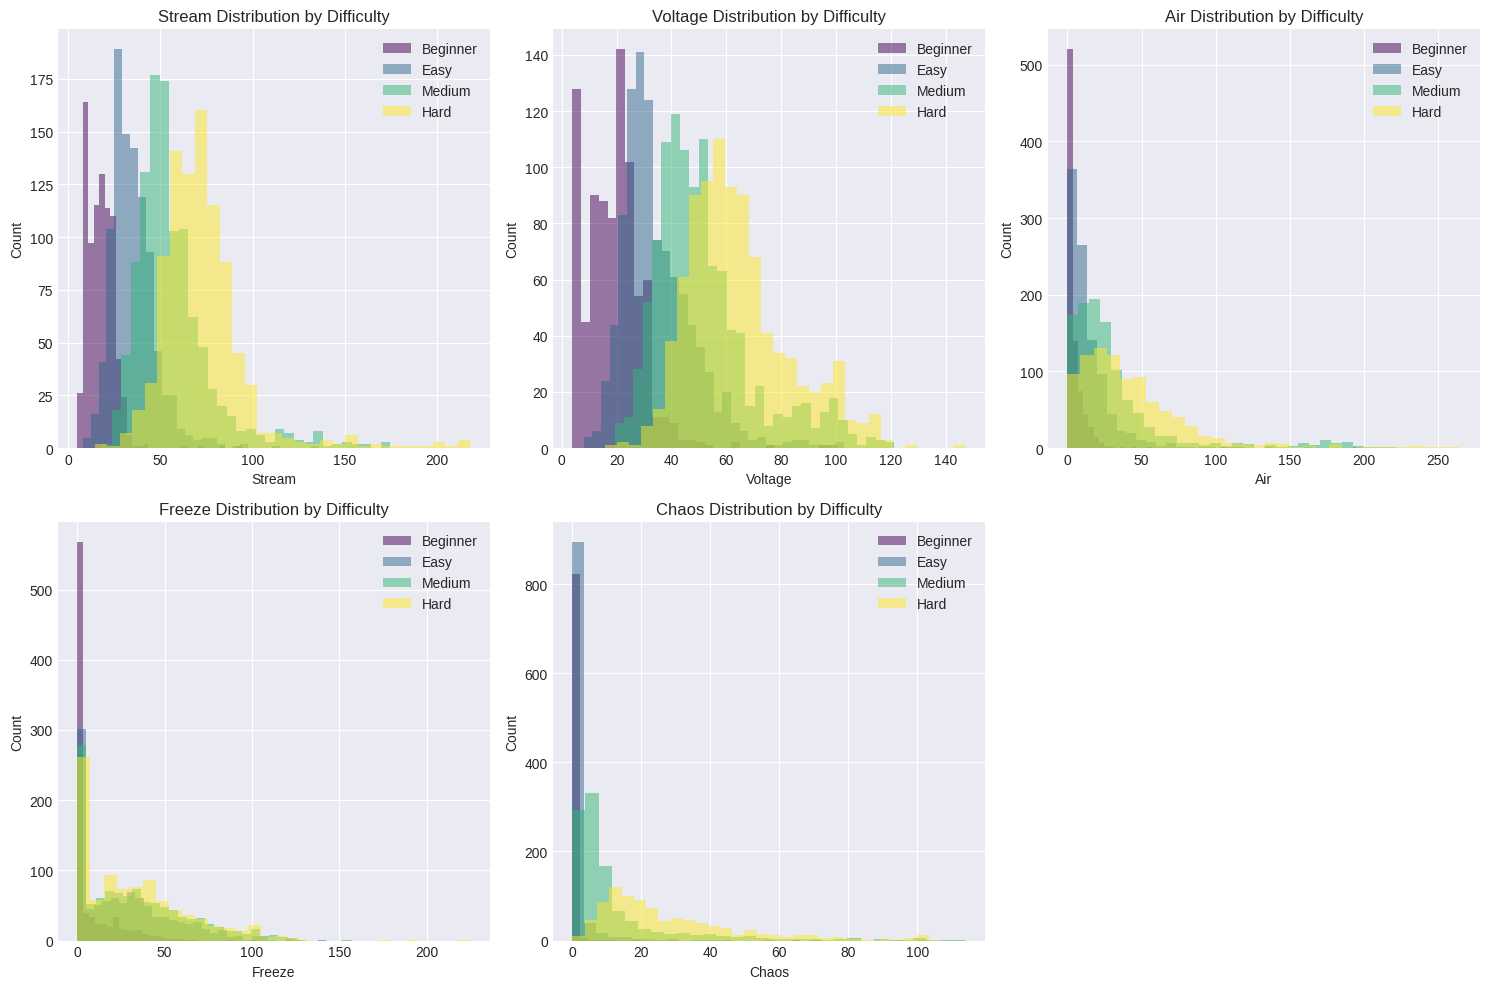

In [8]:
# Groove radar distributions by difficulty
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, len(DIFFICULTY_NAMES)))

for i, name in enumerate(radar_names):
    ax = axes[i]
    for diff_idx, diff_name in enumerate(DIFFICULTY_NAMES):
        mask = difficulties_arr == diff_idx
        if mask.sum() > 0:
            values = radar_raw[mask, i]
            ax.hist(values, bins=30, alpha=0.5, label=diff_name, color=colors[diff_idx])
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Distribution by Difficulty')
    ax.legend()

# Hide unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

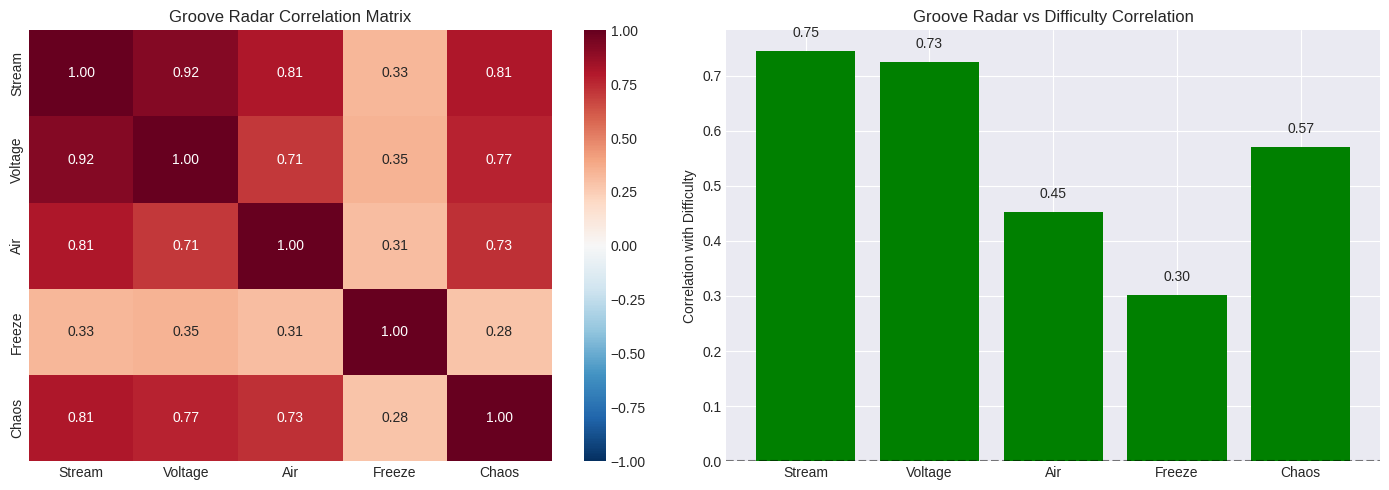

In [9]:
# Correlation heatmap between groove radar dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Radar correlation
ax = axes[0]
corr = np.corrcoef(radar_raw.T)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=radar_names, yticklabels=radar_names, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Groove Radar Correlation Matrix')

# Radar-difficulty correlation
ax = axes[1]
radar_diff_corr = []
for i in range(5):
    corr_val = np.corrcoef(radar_raw[:, i], difficulties_arr)[0, 1]
    radar_diff_corr.append(corr_val)

bars = ax.bar(radar_names, radar_diff_corr, color=['green' if c > 0 else 'red' for c in radar_diff_corr])
ax.set_ylabel('Correlation with Difficulty')
ax.set_title('Groove Radar vs Difficulty Correlation')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
for bar, val in zip(bars, radar_diff_corr):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02 * np.sign(val),
            f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top')

plt.tight_layout()
plt.show()

/tmp/ipykernel_249121/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
/tmp/ipykernel_249121/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
/tmp/ipykernel_249121/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
/tmp/ipykernel_249121/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplo

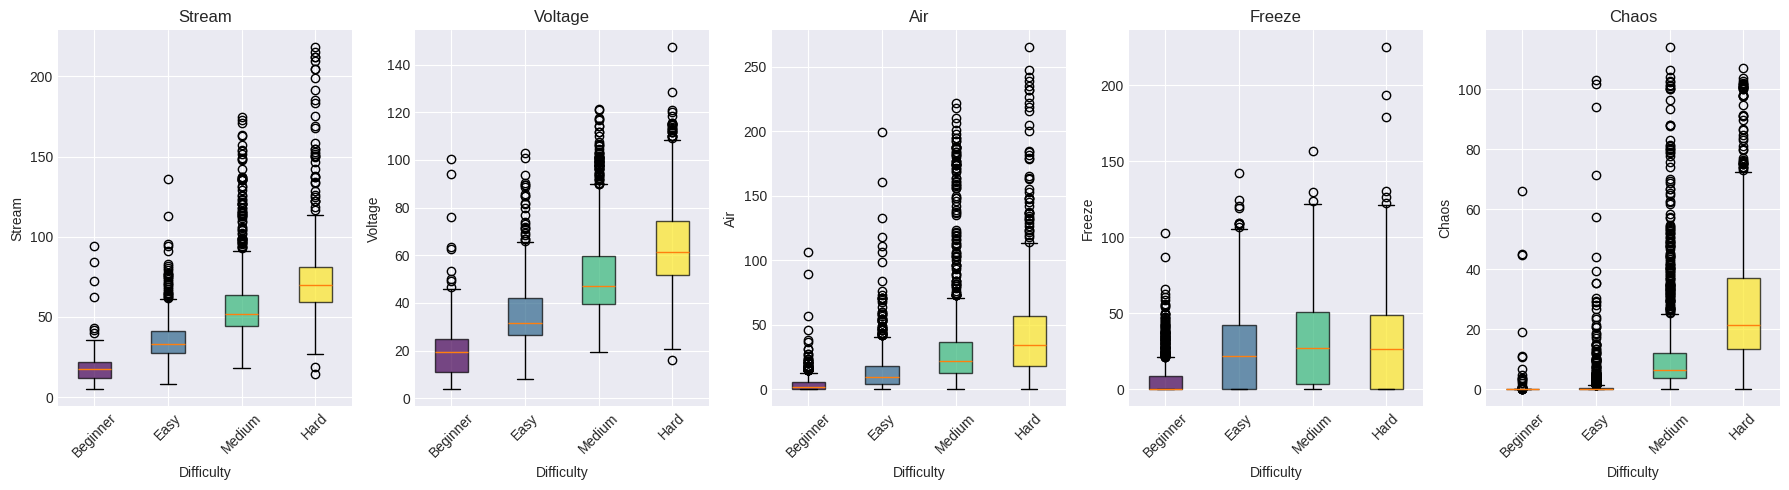

In [10]:
# Groove radar boxplot by difficulty
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

for i, name in enumerate(radar_names):
    ax = axes[i]
    data_by_diff = [radar_raw[difficulties_arr == d, i] for d in range(len(DIFFICULTY_NAMES))]
    bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_xlabel('Difficulty')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Triplet Selection Analysis

In [11]:
# Configure triplet selector
radar_weights = contrastive_config.get('radar_weights', [1.0, 1.0, 1.0, 1.0, 1.0])
similarity_fn = GrooveRadarSimilarity(weights=np.array(radar_weights))

triplet_selector = TripletSelector(
    similarity_fn=similarity_fn,
    positive_percentile=contrastive_config['positive_percentile'],
    negative_percentile=contrastive_config['negative_percentile'],
    same_difficulty_only=contrastive_config.get('same_difficulty_only', False),
    hard_mining=True
)

# Fit to training data
triplet_selector.fit(train_radars, train_difficulties)

print(f"Positive threshold: {triplet_selector.positive_threshold:.4f}")
print(f"Negative threshold: {triplet_selector.negative_threshold:.4f}")

TripletSelector fitted: positive_threshold=0.0960, negative_threshold=0.2951
Positive threshold: 0.0960
Negative threshold: 0.2951


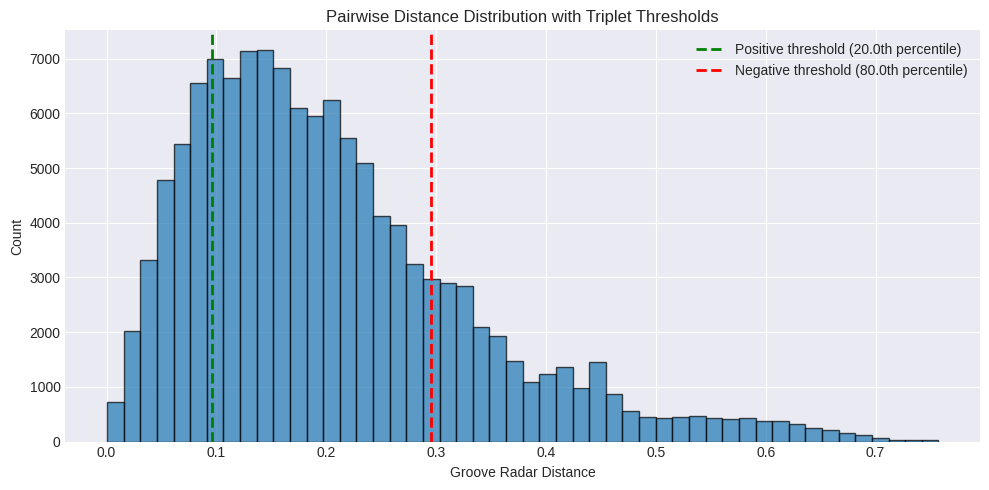

Distance stats: mean=0.2047, std=0.1293
Distance range: [0.0004, 0.7572]


In [12]:
# Visualize distance distribution and thresholds
# Sample pairwise distances
n_samples = min(500, len(train_radars))
sample_indices = np.random.choice(len(train_radars), n_samples, replace=False)

distances = []
for i in range(len(sample_indices)):
    for j in range(i + 1, len(sample_indices)):
        d = similarity_fn.distance(train_radars[sample_indices[i]], train_radars[sample_indices[j]])
        distances.append(d)

distances = np.array(distances)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(distances, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(triplet_selector.positive_threshold, color='green', linestyle='--', linewidth=2,
           label=f'Positive threshold ({triplet_selector.positive_percentile}th percentile)')
ax.axvline(triplet_selector.negative_threshold, color='red', linestyle='--', linewidth=2,
           label=f'Negative threshold ({triplet_selector.negative_percentile}th percentile)')
ax.set_xlabel('Groove Radar Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distance Distribution with Triplet Thresholds')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Distance stats: mean={distances.mean():.4f}, std={distances.std():.4f}")
print(f"Distance range: [{distances.min():.4f}, {distances.max():.4f}]")

In [13]:
# Get triplet selection statistics
stats = triplet_selector.get_statistics(train_radars, train_difficulties)

print("Triplet Selection Statistics:")
print(f"  Total samples: {stats['total_samples']}")
print(f"  Samples with valid positives: {stats['has_positive']} ({stats['has_positive']/stats['total_samples']:.1%})")
print(f"  Samples with valid negatives: {stats['has_negative']} ({stats['has_negative']/stats['total_samples']:.1%})")
print(f"  Samples with both (valid anchors): {stats['has_both']} ({stats['valid_anchor_ratio']:.1%})")

Triplet Selection Statistics:
  Total samples: 3820
  Samples with valid positives: 3814 (99.8%)
  Samples with valid negatives: 3820 (100.0%)
  Samples with both (valid anchors): 3814 (99.8%)


## 5. Create Contrastive Dataset

In [14]:
# Create contrastive dataset
contrastive_train_dataset = create_contrastive_dataset(
    base_dataset=train_dataset,
    radar_weights=radar_weights,
    positive_percentile=contrastive_config['positive_percentile'],
    negative_percentile=contrastive_config['negative_percentile'],
    precompute=contrastive_config.get('precompute_triplets', True),
    resample=contrastive_config.get('resample_epoch', True)
)

triplet_stats = contrastive_train_dataset.get_triplet_statistics()
print(f"\nContrastive dataset:")
print(f"  Number of triplets: {triplet_stats['num_triplets']}")
print(f"  Base dataset size: {triplet_stats['base_dataset_size']}")

Fitting triplet selector...
TripletSelector fitted: positive_threshold=0.0954, negative_threshold=0.2969
Triplet selection stats: 3814/3820 (99.8%) samples can form valid triplets
Precomputing triplets...
Precomputed 3814 triplets

Contrastive dataset:
  Number of triplets: 3814
  Base dataset size: 3820


In [15]:
# Inspect a sample triplet
sample_triplet = contrastive_train_dataset[0]
print("Sample triplet keys:")
for key in sorted(sample_triplet.keys()):
    value = sample_triplet[key]
    if isinstance(value, torch.Tensor):
        print(f"  {key}: shape={tuple(value.shape)}, dtype={value.dtype}")
    else:
        print(f"  {key}: {type(value).__name__}")

/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:202: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(


Sample triplet keys:
  anchor_audio: shape=(1440, 23), dtype=torch.float32
  anchor_chart: shape=(1440, 4), dtype=torch.float32
  anchor_difficulty: shape=(), dtype=torch.int64
  anchor_difficulty_value: shape=(), dtype=torch.int64
  anchor_groove_radar: shape=(5,), dtype=torch.float32
  anchor_length: int
  anchor_mask: shape=(1440,), dtype=torch.bool
  negative_audio: shape=(1440, 23), dtype=torch.float32
  negative_chart: shape=(1440, 4), dtype=torch.float32
  negative_difficulty: shape=(), dtype=torch.int64
  negative_difficulty_value: shape=(), dtype=torch.int64
  negative_groove_radar: shape=(5,), dtype=torch.float32
  negative_length: int
  negative_mask: shape=(1440,), dtype=torch.bool
  positive_audio: shape=(1440, 23), dtype=torch.float32
  positive_chart: shape=(1440, 4), dtype=torch.float32
  positive_difficulty: shape=(), dtype=torch.int64
  positive_difficulty_value: shape=(), dtype=torch.int64
  positive_groove_radar: shape=(5,), dtype=torch.float32
  positive_length: in

In [16]:
# Create data loaders with optimized settings
batch_size = training_config['batch_size']
num_workers = 4
pin_memory = device.type == 'cuda'
persistent_workers = num_workers > 0
prefetch_factor = 4 if num_workers > 0 else None

train_loader = DataLoader(
    contrastive_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor,
    drop_last=True  # Consistent batch sizes for training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"DataLoader settings: persistent_workers={persistent_workers}, prefetch_factor={prefetch_factor}")

Train batches: 59
Val batches: 13
DataLoader settings: persistent_workers=True, prefetch_factor=4


## 6. Create Model with Projection Head

In [17]:
# Enable projection head for contrastive learning
model_config = classifier_config.copy()
model_config['use_projection_head'] = True
model_config['projection_dim'] = contrastive_config.get('projection_dim', 128)
model_config['use_groove_radar'] = True  # Use groove radar features

model = LateFusionClassifier(model_config)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created with projection head")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Projection dimension: {model_config['projection_dim']}")

Model created with projection head
  Total parameters: 2,818,916
  Trainable parameters: 2,818,916
  Projection dimension: 128


In [18]:
# Test forward pass with a sample batch
sample_batch = next(iter(train_loader))

with torch.no_grad():
    anchor_audio = sample_batch['anchor_audio'].to(device)
    anchor_chart = sample_batch['anchor_chart'].to(device)
    anchor_mask = sample_batch['anchor_mask'].to(device)
    anchor_radar = sample_batch['anchor_groove_radar'].to(device)
    
    output = model(
        anchor_audio, anchor_chart, anchor_mask,
        groove_radar=anchor_radar,
        return_embeddings=True
    )

print(f"Forward pass successful!")
print(f"  Logits shape: {output['logits'].shape}")
print(f"  Embeddings shape: {output['embeddings'].shape}")

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_com

Forward pass successful!
  Logits shape: torch.Size([64, 4])
  Embeddings shape: torch.Size([64, 128])


## 7. Train with ContrastiveTrainer

In [19]:
# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_config['learning_rate'],
    weight_decay=training_config.get('weight_decay', 0.01)
)

# Merge configs for trainer
trainer_config = {
    **training_config,
    **contrastive_config,
    'num_classes': classifier_config['num_classes']
}

# Create trainer
trainer = ContrastiveTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    config=trainer_config,
    checkpoint_dir=str(CHECKPOINT_DIR),
    device=device
)

print(f"ContrastiveTrainer initialized")
print(f"  Classification weight: {trainer.classification_weight}")
print(f"  Contrastive weight: {trainer.contrastive_weight}")

Using device: cuda
Using mixed precision training (AMP)
Using class weights: [1.1423444747924805, 0.9646464586257935, 0.8809962868690491, 1.0494505167007446]
Using multi-task loss: 0.8*classification + 1.0*contrastive (triplet_radar)
ContrastiveTrainer initialized
  Classification weight: 0.8
  Contrastive weight: 1.0


In [20]:
# Optional: Load from checkpoint to resume training
resume_checkpoint = None  # Set to path to resume, e.g., CHECKPOINT_DIR / 'last.pt'

if resume_checkpoint and Path(resume_checkpoint).exists():
    trainer.load_checkpoint(str(resume_checkpoint))
    print(f"Resumed from {resume_checkpoint}")

In [ ]:
# Train!
history = trainer.fit()

Starting contrastive training for 15 epochs (from epoch 1)
Checkpoints will be saved to: ../checkpoints/contrastive


Train Epoch 1:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comm

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 1:  20%|▏| 12/59 [08:24<09:10, 11.71s/it, loss=2.2465, cls=1.3602, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 1:  54%|▌| 32/59 [14:33<04:38, 10.30s/it, loss=2.0195, cls=1.3597, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 1:  95%|▉| 56/59 [21:50<00:30, 10.23s/it, loss=1.7275, cls=1.2616, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

Epoch 1:
  Train Loss: 2.0917 (cls: 1.3522, ctr: 1.0100)
  Train Acc: 0.3387
  Val Loss: 1.1724, Val Acc: 0.5420
  LR: 0.000100
  New best validation loss: 1.1724
Precomputing triplets...
Precomputed 3814 triplets


Train Epoch 2:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

Train Epoch 2:  34%|▎| 20/59 [06:08<06:40, 10.28s/it, loss=1.4786, cls=1.0194, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():58

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 2:  46%|██▊   | 6/13 [00:50<00:47,  6.78s/it, loss=0.8935, acc=0.6426][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 2: 100%|█████| 13/13 [01:17<00

Epoch 2:
  Train Loss: 1.3557 (cls: 0.9900, ctr: 0.5637)
  Train Acc: 0.5734
  Val Loss: 0.9164, Val Acc: 0.6132
  LR: 0.000100
  New best validation loss: 0.9164
Precomputing triplets...
Precomputed 3814 triplets


Train Epoch 3:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

Train Epoch 3:  41%|▍| 24/59 [07:29<05:58, 10.25s/it, loss=0.6564, cls=0.8205, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():58

Val Epoch 3:  46%|██▊   | 6/13 [00:50<00:46,  6.69s/it, loss=0.7997, acc=0.6348][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 3: 100%|█████| 13/13 [01:16<00:00,  5.92s/it, loss=1.0708, acc=0.6107]


Epoch 3:
  Train Loss: 0.7214 (cls: 0.7985, ctr: 0.0826)
  Train Acc: 0.7037
  Val Loss: 0.8397, Val Acc: 0.6107
  LR: 0.000100
  New best validation loss: 0.8397
Precomputing triplets...
Precomputed 3814 triplets


Train Epoch 4:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error

Train Epoch 4:  34%|▎| 20/59 [06:09<06:36, 10.16s/it, loss=0.4838, cls=0.6048, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 4:  75%|▋| 44/59 [13:29<02:38, 10.58s/it, loss=0.5010, cls=0.6263, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 4:  46%|██▊   | 6/13 [00:50<00:47,  6.85s/it, loss=0.7571, acc=0.6348][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 4: 100%|█████| 13/13 [01:17<00:00,  5.96s/it, loss=1.0958, acc=0.6196]


Epoch 4:
  Train Loss: 0.5384 (cls: 0.6585, ctr: 0.0116)
  Train Acc: 0.7675
  Val Loss: 0.8288, Val Acc: 0.6196
  LR: 0.000100
  New best validation loss: 0.8288
Precomputing triplets...
Precomputed 3814 triplets


Train Epoch 5:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 5:  41%|▍| 24/59 [07:21<05:56, 10.19s/it, loss=0.5113, cls=0.5933, c[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 5:  75%|▋| 44/59 [13:30<02:38, 10.58s/it, loss=0.5045, cls=0.6306, c[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comm

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 5:  46%|██▊   | 6/13 [00:50<00:47,  6.80s/it, loss=0.6722, acc=0.6543][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

Epoch 5:
  Train Loss: 0.5290 (cls: 0.5853, ctr: 0.0608)
  Train Acc: 0.7905
  Val Loss: 0.7581, Val Acc: 0.6387
  LR: 0.000100
  New best validation loss: 0.7581
Precomputing triplets...
Precomputed 3814 triplets


Train Epoch 6:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Train Epoch 6:  34%|▎| 20/59 [06:10<06:31, 10.03s/it, loss=0.4510, cls=0.5637, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

Train Epoch 6:  68%|▋| 40/59 [12:20<03:23, 10.69s/it, loss=0.5184, cls=0.6480, c[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1908] error: dequantization failed!
[src/libmpg123/id3.c:process_comment():587] error: No comm

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 6:  46%|██▊   | 6/13 [00:51<00:47,  6.82s/it, loss=0.5743, acc=0.6992][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Val Epoch 6: 100%|█████| 13/13 [01:19<00:00,  6.08s/it, loss=0.8800, acc=0.6883]


Epoch 6:
  Train Loss: 0.4568 (cls: 0.5354, ctr: 0.0285)
  Train Acc: 0.8167
  Val Loss: 0.6954, Val Acc: 0.6883
  LR: 0.000100
  New best validation loss: 0.6954
Precomputing triplets...
Precomputed 3814 triplets


Train Epoch 7:   0%|                                     | 0/59 [00:00<?, ?it/s][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():5

## 8. Training Analysis

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Total loss
ax = axes[0, 0]
ax.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
ax.plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Total Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Component losses
ax = axes[0, 1]
ax.plot(epochs, history['train_cls_loss'], 'g-', label='Classification', linewidth=2)
ax.plot(epochs, history['train_contrastive_loss'], 'purple', label='Contrastive', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Components')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[1, 0]
ax.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
ax.plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Generalization gap
ax = axes[1, 1]
gap = np.array(history['val_loss']) - np.array(history['train_loss'])
ax.plot(epochs, gap, 'purple', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.fill_between(epochs, 0, gap, where=(gap > 0), color='red', alpha=0.3, label='Overfitting')
ax.fill_between(epochs, 0, gap, where=(gap <= 0), color='green', alpha=0.3, label='Underfitting')
ax.set_xlabel('Epoch')
ax.set_ylabel('Val Loss - Train Loss')
ax.set_title('Generalization Gap')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print(f"\nTraining Summary:")
print(f"  Best validation loss: {min(history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history['val_acc']):.4f}")
print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"  Final val accuracy: {history['val_acc'][-1]:.4f}")

## 9. Embedding Space Visualization

Use t-SNE to visualize the learned embedding space.

In [ ]:
# Extract embeddings from validation set
@torch.no_grad()
def extract_embeddings(model, dataloader, device, max_samples=500):
    """Extract embeddings and labels from a dataloader."""
    model.eval()
    
    all_embeddings = []
    all_labels = []
    all_groove_radars = []
    
    total = 0
    for batch in tqdm(dataloader, desc="Extracting embeddings"):
        audio = batch['audio'].to(device)
        chart = batch['chart'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['difficulty']
        groove_radar = batch.get('groove_radar')
        if groove_radar is not None:
            groove_radar = groove_radar.to(device)
        
        output = model(audio, chart, mask, groove_radar=groove_radar, return_embeddings=True)
        
        all_embeddings.append(output['embeddings'].cpu().numpy())
        all_labels.append(labels.numpy())
        if groove_radar is not None:
            all_groove_radars.append(groove_radar.cpu().numpy())
        
        total += labels.size(0)
        if total >= max_samples:
            break
    
    embeddings = np.concatenate(all_embeddings, axis=0)[:max_samples]
    labels = np.concatenate(all_labels, axis=0)[:max_samples]
    groove_radars = np.concatenate(all_groove_radars, axis=0)[:max_samples] if all_groove_radars else None
    
    return embeddings, labels, groove_radars

embeddings, labels, groove_radars = extract_embeddings(model, val_loader, device)
print(f"Extracted {len(embeddings)} embeddings")

In [ ]:
# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
print("t-SNE complete!")

In [ ]:
# Visualize t-SNE embeddings colored by difficulty
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# By difficulty class
ax = axes[0]
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels, cmap='viridis', alpha=0.6, s=20)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Difficulty Class')
cbar.set_ticks(range(len(DIFFICULTY_NAMES)))
cbar.set_ticklabels(DIFFICULTY_NAMES)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Embedding Space (by Difficulty)')

# By Stream (first groove radar component)
ax = axes[1]
if groove_radars is not None:
    stream_values = groove_radars[:, 0]  # First component (Stream) - already normalized
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=stream_values, cmap='plasma', alpha=0.6, s=20)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Stream (normalized)')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title('Embedding Space (by Stream)')
else:
    ax.text(0.5, 0.5, 'No groove radar data', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [ ]:
# Embedding space colored by each groove radar dimension
if groove_radars is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (ax, name) in enumerate(zip(axes[:5], radar_names)):
        scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=groove_radars[:, i], cmap='plasma', alpha=0.6, s=20)
        plt.colorbar(scatter, ax=ax, label=name)
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.set_title(f'Embedding Space (by {name})')
    
    axes[5].axis('off')
    plt.tight_layout()
    plt.show()

## 10. Triplet Quality Analysis

Analyze how well the contrastive learning is separating samples.

In [ ]:
# Compute embedding distances for triplets
@torch.no_grad()
def analyze_triplet_distances(model, train_loader, device, n_batches=10):
    """Analyze distances between anchor-positive and anchor-negative in embedding space."""
    model.eval()
    
    ap_distances = []  # Anchor-Positive distances
    an_distances = []  # Anchor-Negative distances
    
    for i, batch in enumerate(train_loader):
        if i >= n_batches:
            break
            
        # Get embeddings for anchor, positive, negative
        anchor_out = model(
            batch['anchor_audio'].to(device),
            batch['anchor_chart'].to(device),
            batch['anchor_mask'].to(device),
            groove_radar=batch['anchor_groove_radar'].to(device),
            return_embeddings=True
        )
        positive_out = model(
            batch['positive_audio'].to(device),
            batch['positive_chart'].to(device),
            batch['positive_mask'].to(device),
            groove_radar=batch['positive_groove_radar'].to(device),
            return_embeddings=True
        )
        negative_out = model(
            batch['negative_audio'].to(device),
            batch['negative_chart'].to(device),
            batch['negative_mask'].to(device),
            groove_radar=batch['negative_groove_radar'].to(device),
            return_embeddings=True
        )
        
        # Compute distances
        ap_dist = torch.norm(anchor_out['embeddings'] - positive_out['embeddings'], dim=1)
        an_dist = torch.norm(anchor_out['embeddings'] - negative_out['embeddings'], dim=1)
        
        ap_distances.extend(ap_dist.cpu().numpy().tolist())
        an_distances.extend(an_dist.cpu().numpy().tolist())
    
    return np.array(ap_distances), np.array(an_distances)

ap_distances, an_distances = analyze_triplet_distances(model, train_loader, device)
print(f"Analyzed {len(ap_distances)} triplets")

In [ ]:
# Plot distance distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(ap_distances, bins=50, alpha=0.5, label='Anchor-Positive', color='green')
ax.hist(an_distances, bins=50, alpha=0.5, label='Anchor-Negative', color='red')
ax.set_xlabel('Embedding Distance')
ax.set_ylabel('Count')
ax.set_title('Triplet Distance Distribution')
ax.legend()

# Margin analysis
ax = axes[1]
margins = an_distances - ap_distances
ax.hist(margins, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero margin')
ax.axvline(contrastive_config['triplet_margin'], color='green', linestyle='--', 
           linewidth=2, label=f'Target margin ({contrastive_config["triplet_margin"]})')
ax.set_xlabel('Margin (AN - AP distance)')
ax.set_ylabel('Count')
ax.set_title('Triplet Margin Distribution')
ax.legend()

plt.tight_layout()
plt.show()

# Statistics
satisfied = (margins > 0).sum()
print(f"\nTriplet Statistics:")
print(f"  Mean AP distance: {ap_distances.mean():.4f}")
print(f"  Mean AN distance: {an_distances.mean():.4f}")
print(f"  Mean margin: {margins.mean():.4f}")
print(f"  Triplets with positive margin: {satisfied}/{len(margins)} ({satisfied/len(margins):.1%})")

## 11. Save Results

In [ ]:
# Save final results summary
results = {
    'training_config': trainer_config,
    'best_val_loss': min(history['val_loss']),
    'best_val_acc': max(history['val_acc']),
    'final_train_acc': history['train_acc'][-1],
    'final_val_acc': history['val_acc'][-1],
    'num_epochs': len(history['train_loss']),
    'triplet_stats': {
        'mean_ap_distance': float(ap_distances.mean()),
        'mean_an_distance': float(an_distances.mean()),
        'mean_margin': float(margins.mean()),
        'positive_margin_ratio': float(satisfied / len(margins))
    }
}

results_path = CHECKPOINT_DIR / 'training_results.yaml'
with open(results_path, 'w') as f:
    yaml.dump(results, f, default_flow_style=False)

print(f"Results saved to {results_path}")

In [ ]:
print("\n" + "="*50)
print("CONTRASTIVE TRAINING COMPLETE")
print("="*50)
print(f"\nCheckpoints saved to: {CHECKPOINT_DIR}")
print(f"Best model: {CHECKPOINT_DIR / 'best_val_loss.pt'}")
print(f"\nFinal Results:")
print(f"  Validation Accuracy: {results['best_val_acc']:.4f}")
print(f"  Triplet Margin Ratio: {results['triplet_stats']['positive_margin_ratio']:.1%}")